In [1]:
import sys
import os
path_pipest = os.path.abspath('./')
n=0
while (not os.path.basename(path_pipest)=='pipest') and (n<4):
    path_pipest=os.path.dirname(path_pipest)
    n+=1 
if not os.path.basename(path_pipest)=='pipest':
    print("path_pipest not found. Instead: {}".format(path_pipest))
    raise ValueError("path_pipest not found.")
path_models=path_pipest+'/models'    
path_sdhawkes=path_pipest+'/sdhawkes_powerlaw'
path_modelling = path_sdhawkes+'/modelling'
path_resources = path_sdhawkes+'/resources'
path_lobster=path_pipest+'/lobster_for_sdhawkes'
path_lobster_data=path_lobster+'/data'
path_lobster_pyscripts=path_lobster+'/py_scripts'
path_tests = path_pipest+'/tests'
path_saved_tests = path_tests+'/saved_tests'
path_perfmeas=path_tests+'/performance_measurements'
sys.path.append(path_modelling)
sys.path.append(path_resources)
sys.path.append(path_perfmeas)
import numpy as np
import pandas as pd
import pickle
import datetime
import time
import datetime
import timeit
import model as sd_hawkes_model
import plot_tools

openmp.omp_get_max_threads(): 4
openmp.omp_get_max_threads(): 4


In [2]:
n_states=[3,5] 
n_events = 4  # number of event types, $d_E$
n_levels = 2
upto_level = 2
time_start=0.0
time_end=time_start+1.0*60 # one minute
model = sd_hawkes_model.SDHawkes(
    number_of_event_types=n_events, list_of_n_states=n_states,
    number_of_lob_levels=n_levels, volume_imbalance_upto_level=upto_level)

In [3]:
d_E=model.number_of_event_types
d_S=model.number_of_states
print("d_E={}; d_S={}".format(d_E,d_S))

d_E=4; d_S=15


In [4]:
model.volume_enc.volimb_limits

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [14]:
model.state_enc.df_state_enc

,st_1,st_2,one_dim_label,multidim_label
0,0,0,0,"(0, 0)"
1,0,1,1,"(0, 1)"
2,0,2,2,"(0, 2)"
3,0,3,3,"(0, 3)"
4,0,4,4,"(0, 4)"
5,1,0,5,"(1, 0)"
6,1,1,6,"(1, 1)"
7,1,2,7,"(1, 2)"
8,1,3,8,"(1, 3)"
9,1,4,9,"(1, 4)"


Assign arbitrary values to the Hawkes parameters $\nu_{e}$, $\alpha_{e',x',e}$ and $\beta_{e',x',e}$

In [6]:
nus = np.array([0.0,0.0,1.0,1.0],dtype=np.float)
alphas = np.maximum(
    np.concatenate(
        [0.2*np.ones((d_E,d_S,d_E//2),dtype=np.float),np.zeros((d_E,d_S,d_E-d_E//2),dtype=np.float)],
        axis=2),
    np.random.uniform(-0.5,0.5,size=(d_E, d_S, d_E))
)
betas = np.exp(np.minimum(2.0,np.random.uniform(0.0001,4.0,size=(d_E, d_S, d_E))))
model.set_hawkes_parameters(nus,alphas,betas)

Hawkes parameters have been set


Assign arbitrary values to the transition matrices $\phi_{e}$, for $e=0,\dots,d_E -1$

In [7]:
phis = model.state_enc.generate_random_transition_prob(n_events=d_E)
model.set_transition_probabilities(phis)

SDHawkes: asymmetry in transition_probabilities = 10.831443933177141
Transition probabilities have been set


Assign arbitrary values to the Dirichlet parameters $\gamma_{x}$ for $x = 0,\dots,d_{S}-1$

In [8]:
gammas = np.random.uniform(low=1.5, high = 5.6,size=(d_S,2*n_levels))
model.set_dirichlet_parameters(gammas)

Dirichlet parameters have been set


In [9]:
model.simulate(time_start, time_end,
               max_number_of_events=10000,
               add_initial_cond=True,store_results=True, report_full_volumes=False)

Simulation is being performed on the following machine:
 posix.uname_result(sysname='Linux', nodename='claudio-HP-EliteBook-850-G3', release='5.3.0-51-generic', version='#44~18.04.2-Ubuntu SMP Thu Apr 23 14:27:18 UTC 2020', machine='x86_64')
SDHawkes.simulate: initial conditions have been acknowledged
I am adding initial conditions on the negative time axis
sd_hawkes_powerlaw_simulation.simulate: start of initialisation
   Number of levels in the order book: 2
   number_of_initial_events=61
sd_hawkes_powerlaw_simulation: simulate: labelled_times and count have been initialised.
sd_hawkes_powerlaw_simulation: simulate: intensities have been initialised.
  intensities at start: [0.00577108 0.00168228 1.00000028 1.00008327]
  intensity_overall at start: 2.007536919579943
sd_hawkes_powerlaw_simulation.simulate: start of simulation
  time_start=0.0,  time at start =0.0
 Simulation terminates. time at end =60.051155418703665,  num_of_event=315
sd_hawkes_powerlaw_simulation: simulate. run_tim

In [10]:
model.store_history_of_intensities(density_of_eval_points=5000)

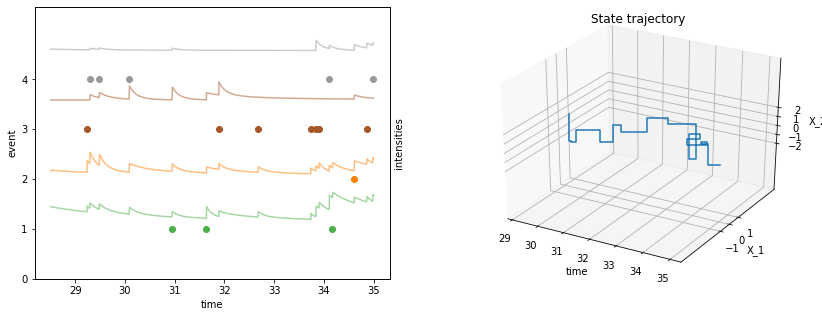

In [11]:
model.plot_events_and_states(t_0=28.5,t_1=35.0)

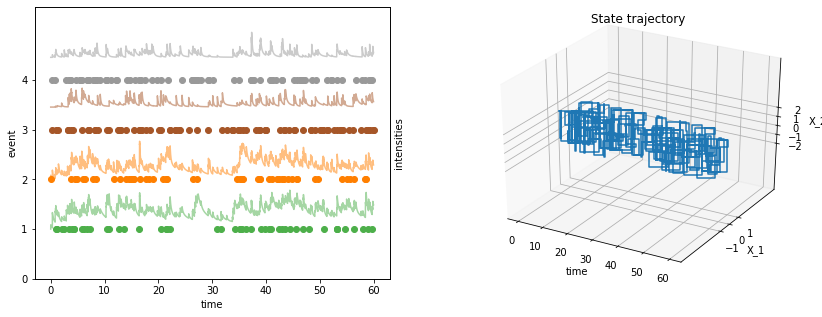

In [12]:
model.plot_events_and_states()

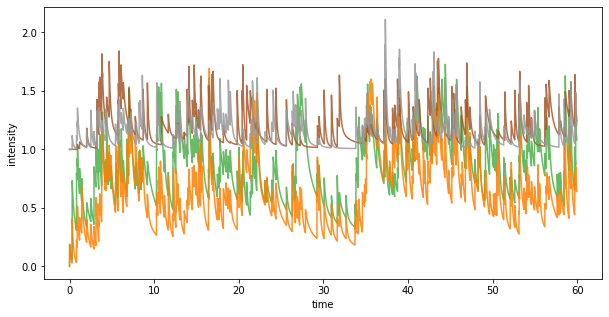

In [13]:
model.plot_intensities()